In [1]:
import pyspark 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
import pyspark.sql.functions as F
from pyspark.sql import Row

In [4]:
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram

In [5]:
train = '/Users/bachhongthai/Desktop/BigData/train.csv'
test = '/Users/bachhongthai/Desktop/BigData/test.csv'

In [6]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("nyc-taxi").getOrCreate()

In [7]:
train_data = spark.read.csv(train, header = True, inferSchema \
                           = True, mode="DROPMALFORMED")
test_data = spark.read.csv(test, header = True, inferSchema \
                          = True, mode="DROPMALFORMED")

In [8]:
# EDA

In [9]:
print('Number of train_data records: ', (train_data.count(), len(train_data.columns)))
print('Number of test_data records:', (test_data.count(), len(test_data.columns)))

Number of train_data records:  (55423856, 8)
Number of test_data records: (9914, 7)


In [10]:
train_data.show(5)

+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|                 key|fare_amount|     pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+--------------------+-----------+--------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:...|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:...|       16.9|2010-01-05 16:52:...|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:...|        5.7|2011-08-18 00:35:...|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:...|        7.7|2012-04-21 04:30:...|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:..

In [11]:
train_data.columns

['key',
 'fare_amount',
 'pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count']

In [12]:
train_data.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: string (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [13]:
# Change data type from String to Timestamp (pickup_datetime).

In [13]:
import pyspark.sql.functions as F

In [14]:
train_data = train_data.withColumn("pickup_datetime", F.to_timestamp(F.col("pickup_datetime"), 
                                                                     "yyyy-MM-dd HH:mm:ss"))

In [15]:
# Now datatype of pickup_datetime is timestamp

In [16]:
train_data.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)



In [17]:
def create_date_columns():
    # Get datetime.date objects and create a new column pickup_date
    new_train_data = train_data.withColumn("pickup_date", F.to_date(F.col("pickup_datetime")))
    new_train_data = new_train_data.withColumn("pickup_day", F.dayofmonth(F.col("pickup_datetime")))
    new_train_data = new_train_data.withColumn("pickup_hour", F.hour(F.col("pickup_datetime")))
    new_train_data = new_train_data.withColumn("pickup_day_of_week", F.dayofweek(F.col("pickup_datetime")))
    new_train_data = new_train_data.withColumn("pickup_month", F.month(F.col("pickup_datetime")))
    new_train_data = new_train_data.withColumn("pickup_year", F.year(F.col("pickup_datetime")))
    
    return new_train_data

In [18]:
new_train_data = create_date_columns()

In [19]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

DataFrame[key: string, value: string]

In [20]:
new_train_data.show(5)

+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1| 2009-06-15|        15|         17|                 2|           6|       2009|
|2010-01-05 16:52:...|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|      

In [21]:
new_train_data.printSchema()

root
 |-- key: string (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day_of_week: integer (nullable = true)
 |-- pickup_month: integer (nullable = true)
 |-- pickup_year: integer (nullable = true)



In [22]:
# Now we can see a pickup_date, pickup_day, pickup_hour, pickup_day_of_week, pickup_month, pickup_year 
# All of them has created from pickup_datetime after convert from string type to datetime type. 

In [23]:
###

In [24]:
# Next, i will checking NULL entries in dataset

In [25]:
new_train_data.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in new_train_data.columns]).show()

+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|  0|          0|              0|               0|              0|              376|             376|              0|          0|         0|          0|                 0|           0|          0|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+



In [26]:
# We have 376 NULL entries in two row is dropoff_longitude and dropoff_latitude
# Now we will cleaning NULL emtries.

In [27]:
print('Length before removal', new_train_data.count())
new_train_data = new_train_data.filter(new_train_data.dropoff_longitude.isNotNull())
new_train_data = new_train_data.filter(new_train_data.dropoff_latitude.isNotNull())
print('Length after removal', new_train_data.count())

Length before removal 55423856
Length after removal 55423480


In [28]:
# Before removal NULL in dataset, we have 55423856 row
# After clearning we also have 55423480 in dataset.

In [29]:
# Next, we will Visualizations data set

In [31]:
print("Maximum Fare:{}\n Minimum Fare: {}".format(new_train_data.agg({"fare_amount": "max"}).collect()[0],\
      new_train_data.agg({"fare_amount": "min"}).collect()[0]))


Maximum Fare:Row(max(fare_amount)=93963.36)
 Minimum Fare: Row(min(fare_amount)=-300.0)


In [30]:
# As we can see, there are negative fares as well as extremely high fares. 
# While negative fares don't make any sense, based on data of NY Taxi base fares, 
# we know that the base fare is 2.5. So, we remove all records 
# who have fares less than 2.5. Also, we keep the upper limit as 100, based on intuition

In [32]:
train_data_fare_filtered = new_train_data.filter(F.col("fare_amount").between(2.5, 100))

In [33]:
train_data_fare_filtered.show(5)

+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1| 2009-06-15|        15|         17|                 2|           6|       2009|
|2010-01-05 16:52:...|       16.9|2010-01-05 16:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|      

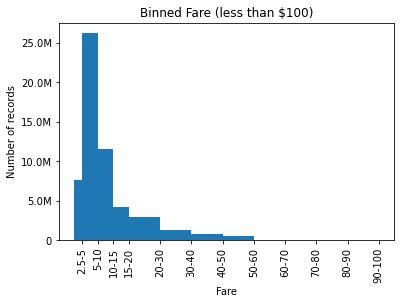

In [35]:
fig = plt.figure()
axes = plt.gca()

ranges = [2.5,5,10,15,20,30,40,50,60,70,80,90,100]

plt.xticks(ticks = ranges[1:], labels= ['2.5-5', '5-10', '10-15', '15-20', '20-30', '30-40', \
            '40-50', '50-60', '60-70','70-80', '80-90', '90-100'], rotation = 'vertical')
plt.title('Binned Fare (less than $100)')
plt.xlabel('Fare')
plt.ylabel('Number of records')

hist(axes, train_data_fare_filtered.select(F.col(("fare_amount"))), bins = ranges)
plt.show()

In [36]:
# We can see from the above plot that trips with fares in the range 
# 2.5(base rate) to 15 is maximum and then there are some trips at the rate of 
#40-60 which can be some other kind of fixed rates.

In [37]:
# Passenger Count Distribution

In [38]:
print("Maximum Passengers:{}\n Minimum Passengers: {}".format(train_data_fare_filtered.agg
                                                              ({"passenger_count": "max"}).collect()[0],\
      train_data_fare_filtered.agg({"passenger_count": "min"}).collect()[0]))

Maximum Passengers:Row(max(passenger_count)=208)
 Minimum Passengers: Row(min(passenger_count)=0)


In [39]:
# Again, we can see that the passenger count has high numbers as well as zero value which does not make sense. 
# we filter only those rows where count is [1,6], that is 7 seater cars

In [34]:
train_data_passenger_filtered = train_data_fare_filtered.filter(F.col("passenger_count").between(1,6))

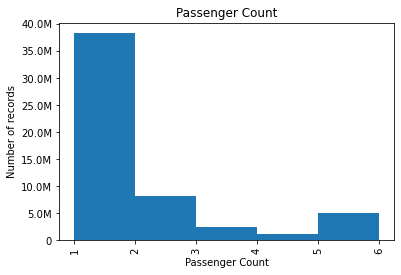

In [35]:
fig = plt.figure()
axes = plt.gca()

ranges = [1,2,3,4,5,6]

plt.xticks(rotation = 'vertical')
plt.title('Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Number of records')

hist(axes, train_data_passenger_filtered.select(F.col(("passenger_count"))), bins = ranges)
plt.show()

In [42]:
train_data_passenger_filtered.count()
# We can see in Passenger Count graph, number of 1 passenger in every car is maximun 
# (Upper 35.0M records in 55202765 records).

55202765

In [36]:
# Next, I will analyzing Coordinates.

In [37]:
# In dataset, we have longitude and latitude when taxi driver pickup and dropoff passenger.

In [38]:
# Below i will show a maximun and minimum value of Longitude and Latitude when pickup

In [46]:
print("Range of Pickup Latitude: ", train_data_passenger_filtered.agg({"pickup_latitude": "max"}).collect()[0],\
      train_data_passenger_filtered.agg({"pickup_latitude": "min"}).collect()[0])
print("Range of Pickup Longitude: ", train_data_passenger_filtered.agg({"pickup_longitude": "max"}).collect()[0],\
      train_data_passenger_filtered.agg({"pickup_longitude": "min"}).collect()[0])

Range of Pickup Latitude:  Row(max(pickup_latitude)=3408.789565) Row(min(pickup_latitude)=-3492.263768)
Range of Pickup Longitude:  Row(max(pickup_longitude)=3457.625683) Row(min(pickup_longitude)=-3442.059565)


In [47]:
# And, a maximun and minimum value of Longitude and Latitude when drop off

In [48]:
print("Range of Dropoff Latitude: ", train_data_passenger_filtered.agg({"dropoff_latitude": "max"}).collect()[0],\
      train_data_passenger_filtered.agg({"dropoff_latitude": "min"}).collect()[0])
print("Range of Dropoff Longitude: ", train_data_passenger_filtered.agg({"dropoff_longitude": "max"}).collect()[0],\
      train_data_passenger_filtered.agg({"dropoff_longitude": "min"}).collect()[0])

Range of Dropoff Latitude:  Row(max(dropoff_latitude)=3537.132528) Row(min(dropoff_latitude)=-3547.886698)
Range of Dropoff Longitude:  Row(max(dropoff_longitude)=3457.62235) Row(min(dropoff_longitude)=-3442.024565)


In [49]:
# 

In [50]:
# Base on Longitude and Latitude in New York is 40.771133, -73.974187.
# Using intuition, we keep the records whose co-ordinates are +/- 2 degrees from the centre

In [51]:
train_data_passenger_filtered.count()

55202765

In [39]:
train_data_filtered = train_data_passenger_filtered.filter((F.col("pickup_latitude").between(38.5, 42.5)))
train_data_filtered = train_data_filtered.filter((F.col("dropoff_latitude").between(38.5, 42.5)))
train_data_filtered = train_data_filtered.filter((F.col("pickup_longitude").between(-76, -72)))
train_data_filtered = train_data_filtered.filter((F.col("dropoff_longitude").between(-76, -72)))

In [53]:
train_data_filtered.count()

54057758

In [1]:
#we see that there are many pickups and drops to and from airports. 
#So, we try to confirm that using the co-ordinates of the airports and comparing the average fare for all trips 
#JFK - John F. Kennedy International Airport
JFK = {
    'min_lng': -73.8352, 
    'min_lat': 40.6195, 
    'max_lng': -73.7401,  
    'max_lat': 40.6659
}

JFK_center=[40.6437, -73.7900]


In [41]:
# Get all pickups from JFK
train_data_JFK_pickup = train_data_filtered.filter(F.col("pickup_latitude").between(JFK['min_lat'], JFK['max_lat']))
train_data_JFK_pickup = train_data_JFK_pickup.filter(F.col("pickup_longitude").between(JFK['min_lng'], JFK['max_lng']))

print('Number of trips with pickups at JFK:', train_data_JFK_pickup.count())

Number of trips with pickups at JFK: 827600


In [42]:
# Get all dropoffs at JFK
train_data_JFK_drops = train_data_filtered.filter(F.col("dropoff_latitude").between(JFK['min_lat'], JFK['max_lat']))
train_data_JFK_drops = train_data_JFK_drops.filter(F.col("dropoff_longitude").between(JFK['min_lng'], JFK['max_lng']))

print('Number of trips with drops at JFK:', train_data_JFK_drops.count())

Number of trips with drops at JFK: 421014


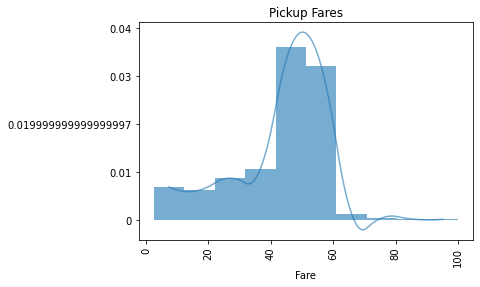

In [57]:
fig = plt.figure()
axes = plt.gca()

plt.xticks(rotation = 'vertical')
plt.title('Pickup Fares')
plt.xlabel('Fare')

distplot(axes, train_data_JFK_pickup.select(F.col(("fare_amount"))), alpha = 0.6)
plt.show()

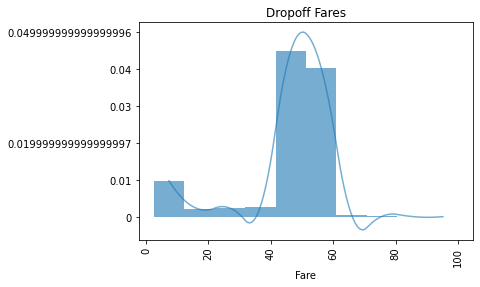

In [58]:
fig = plt.figure()
axes = plt.gca()

plt.xticks(rotation = 'vertical')
plt.title('Dropoff Fares')
plt.xlabel('Fare')

distplot(axes, train_data_JFK_drops.select(F.col(("fare_amount"))), alpha = 0.6)
plt.show()

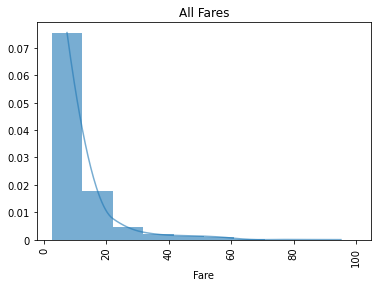

In [59]:
fig = plt.figure()
axes = plt.gca()

plt.xticks(rotation = 'vertical')
plt.title('All Fares')
plt.xlabel('Fare')

distplot(axes, train_data_filtered.select(F.col(("fare_amount"))), alpha = 0.6)
plt.show()

In [60]:
# Feature Engineering

In [61]:
#Airport Data

In [43]:
nyc_airports = {
    'JFK': {
        'min_lng': -73.8352, 
        'min_lat': 40.6195,
        'max_lng': -73.7401,  
        'max_lat': 40.6659
    },     
    'EWR': {
        'min_lng': -74.1925,
        'min_lat': 40.6700, 
        'max_lng': -74.1531, 
        'max_lat': 40.7081
    },
    'LaGuardia': {
        'min_lng': -73.8895, 
        'min_lat': 40.7664, 
        'max_lng': -73.8550, 
        'max_lat': 40.7931
    }
}

In [44]:
from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType

In [45]:
def isTripRelatedToAirport(latitude,longitude,airport_name='JFK'):   
    if ((latitude >= nyc_airports[airport_name]['min_lat']) & 
        (latitude <= nyc_airports[airport_name]['max_lat']) & 
        (longitude >= nyc_airports[airport_name]['min_lng']) & 
       (longitude <= nyc_airports[airport_name]['max_lng'])):
        return True
    else:
        return False

featureEngineeringUDF = udf(lambda x, y, z: isTripRelatedToAirport(x,y,z),BooleanType())
spark.udf.register("featureEngineeringUDF", featureEngineeringUDF)

<function __main__.<lambda>(x, y, z)>

In [46]:
# Now we create 6 new columns related to trips to the three airports JFK, EWR, and La Guardia respectively: one for pickup and one for dropoff from each airport

In [47]:
from pyspark.sql.functions import lit

In [48]:
train_data_filtered = train_data_filtered.withColumn("is_pickup_JFK", 
                                                     featureEngineeringUDF(F.col("pickup_latitude"), \
                                                     F.col("pickup_longitude"), lit("JFK")))
train_data_filtered = train_data_filtered.withColumn("is_dropoff_JFK", 
                                                     featureEngineeringUDF(F.col("dropoff_latitude"), \
                                                     F.col("dropoff_longitude"), lit("JFK")))

In [68]:
train_data_filtered.show(5)

+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1| 2009-06-15|        15|         17|                 2|           6|       2009|        false|         false|
|2010-01-05 

In [49]:
train_data_filtered = train_data_filtered.withColumn("is_pickup_EWR", 
                                                     featureEngineeringUDF(F.col("pickup_latitude"), \
                                                     F.col("pickup_longitude"), lit("EWR")))
train_data_filtered = train_data_filtered.withColumn("is_dropoff_EWR", 
                                                     featureEngineeringUDF(F.col("dropoff_latitude"), \
                                                     F.col("dropoff_longitude"), lit("EWR")))

In [50]:
train_data_filtered.show(5)

+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1| 2009-06-15|        15|         17

In [51]:
train_data_filtered = train_data_filtered.withColumn("is_pickup_LaGuardia", 
                                                     featureEngineeringUDF(F.col("pickup_latitude"), \
                                                     F.col("pickup_longitude"), lit("LaGuardia")))
train_data_filtered = train_data_filtered.withColumn("is_dropoff_LaGuardia", 
                                                     featureEngineeringUDF(F.col("dropoff_latitude"), \
                                                     F.col("dropoff_longitude"), lit("LaGuardia")))

In [52]:
train_data_filtered.show(5)

+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|is_pickup_LaGuardia|is_dropoff_LaGuardia|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+
|2009-06-15 17:26:...|        4.5|2009-06-15 17:2

In [53]:
from pyspark.sql.types import DoubleType, ArrayType, DecimalType
import math

In [54]:
def trip_distance(lat1, lat2, lon1, lon2):
    # pi / 180
    p = 0.017453292519943295
    a = 0.5 - math.cos((lat2 - lat1) * p)/2 + math.cos(lat1 * p) * math.cos(lat2 * p) * (1 - math.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * math.asin(math.sqrt(a))

haversineUDF = udf(lambda a, b, c, d: trip_distance(a,b,c,d), DoubleType())
spark.udf.register("haversineUDF", haversineUDF)

<function __main__.<lambda>(a, b, c, d)>

In [55]:
train_data_filtered = train_data_filtered.withColumn("trip_distance", haversineUDF(F.col("pickup_latitude"), \
                                                     F.col("dropoff_latitude"), F.col("pickup_longitude"), \
                                                     F.col("dropoff_longitude")))
train_data_filtered.show(7)

+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+------------------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|is_pickup_LaGuardia|is_dropoff_LaGuardia|     trip_distance|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+------------

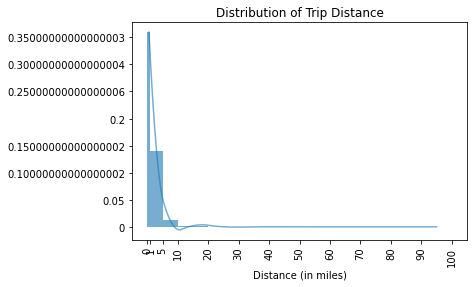

In [76]:
fig = plt.figure()
axes = plt.gca()

ranges = [0,1,5,10,20,30,40,50,60,70,80,90,100]

plt.xticks(ranges, ranges, rotation = 'vertical')
plt.title('Distribution of Trip Distance')
plt.xlabel('Distance (in miles)')

distplot(axes, train_data_filtered.select(F.col(("trip_distance"))), alpha = 0.6, bins=ranges)
plt.show()

In [56]:
nyc_boroughs = {
    'manhattan': {
        'min_lng': -74.0479,
        'min_lat': 40.6829,
        'max_lng': -73.9067,
        'max_lat': 40.8820
    },
    'queens': {
        'min_lng': -73.9630,
        'min_lat': 40.5431,
        'max_lng': -73.7004,
        'max_lat': 40.8007
    },
    'brooklyn': {
        'min_lng': -74.0421,
        'min_lat': 40.5707,
        'max_lng': -73.8334,
        'max_lat': 40.7395
    },
    'bronx': {
        'min_lng': -73.9339,
        'min_lat': 40.7855,
        'max_lng': -73.7654,
        'max_lat': 40.9176
    },
    'staten_island': {
        'min_lng': -74.2558,
        'min_lat': 40.4960,
        'max_lng': -74.0522,
        'max_lat': 40.6490
    }
}

In [57]:
def getBorough(lat,lng):
    locations = nyc_boroughs.keys()
    for location in locations:
        if (lat >= nyc_boroughs[location]['min_lat'] and 
            lat <= nyc_boroughs[location]['max_lat'] and 
            lng >= nyc_boroughs[location]['min_lng'] and 
            lng <= nyc_boroughs[location]['max_lng']):
            return location
    return 'others'

boroughUDF = udf(lambda a, b: getBorough(a,b))
spark.udf.register("boroughUDF", boroughUDF)

<function __main__.<lambda>(a, b)>

In [58]:
train_data_filtered = train_data_filtered.withColumn("pickup_borough", 
                                                     boroughUDF(F.col("pickup_latitude"), \
                                                     F.col("pickup_longitude")))
train_data_filtered = train_data_filtered.withColumn("dropoff_borough", 
                                                     boroughUDF(F.col("dropoff_latitude"), \
                                                     F.col("dropoff_longitude")))

train_data_filtered.show(7)

+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+------------------+--------------+---------------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|is_pickup_LaGuardia|is_dropoff_LaGuardia|     trip_distance|pickup_borough|dropoff_borough|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+------

In [59]:
from pyspark.sql.types import IntegerType

In [60]:
def getBoroughMapping(borough):
    if borough == "manhattan":
        return 1
    elif borough == "queens":
        return 2
    elif borough == "brooklyn":
        return 3
    elif borough == "bronx":
        return 4
    elif borough == "staten_island":
        return 5
    else:
        return 6

bmapUDF = udf(lambda s: getBoroughMapping(s), IntegerType())
spark.udf.register("bmapUDF", bmapUDF)

<function __main__.<lambda>(s)>

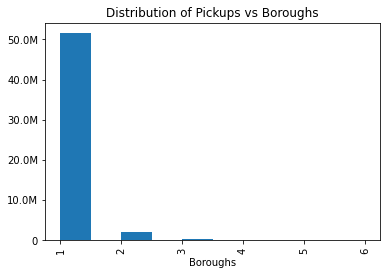

In [83]:
fig = plt.figure()
axes = plt.gca()

plt.xticks(rotation = 'vertical')
plt.title('Distribution of Pickups vs Boroughs')
plt.xlabel('Boroughs')

pickup_boroughs_numeric = train_data_filtered.withColumn("pickup_borough", 
                                                         bmapUDF(F.col("pickup_borough")))

hist(axes, pickup_boroughs_numeric.select(F.col("pickup_borough")))
plt.show()


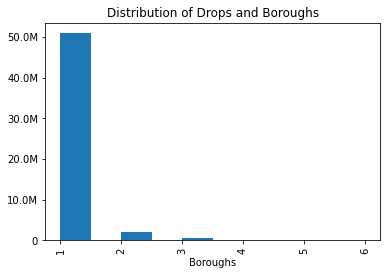

In [84]:
fig = plt.figure()
axes = plt.gca()

plt.xticks(rotation = 'vertical')
plt.title('Distribution of Drops and Boroughs')
plt.xlabel('Boroughs')

dropoff_boroughs_numeric = train_data_filtered.withColumn("dropoff_borough", 
                                                          bmapUDF(F.col("dropoff_borough")))

hist(axes, dropoff_boroughs_numeric.select(F.col("dropoff_borough")))
plt.show()

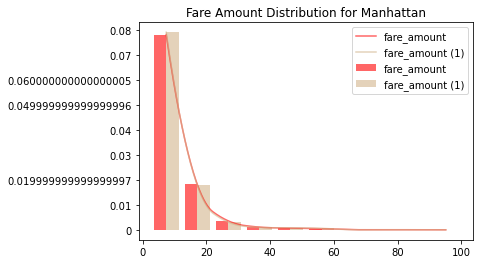

In [85]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount Across Manhattan Borough")

pickup_borough_fares_manhattan = train_data_filtered
.filter(F.col("pickup_borough") == "manhattan")
.select(F.col("fare_amount"))
.alias("pickup_rates")
dropoff_borough_fares_manhattan = train_data_filtered
.filter(F.col("dropoff_borough") == "manhattan")
.select(F.col("fare_amount"))
.alias("dropoff_rates")
    
distplot(axes, [pickup_borough_fares_manhattan
                .select(F.col(("fare_amount"))), 
                dropoff_borough_fares_manhattan
                .select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Manhattan")
axes.legend()

plt.show()

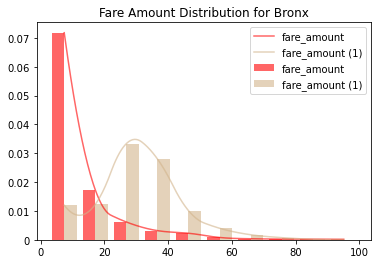

In [86]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount Across Bronx Borough")

pickup_borough_fares_bronx = train_data_filtered
.filter(F.col("pickup_borough") == "bronx")
.select(F.col("fare_amount"))
dropoff_borough_fares_bronx = train_data_filtered
.filter(F.col("dropoff_borough") == "bronx")
.select(F.col("fare_amount"))
    
distplot(axes, [pickup_borough_fares_bronx
                .select(F.col(("fare_amount"))), 
                dropoff_borough_fares_bronx
                .select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Bronx")
axes.legend()

plt.show()

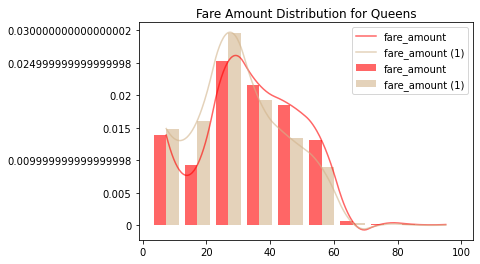

In [87]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount Across Queens")

pickup_borough_fares_queens = train_data_filtered.filter(F.col("pickup_borough") == "queens").select(F.col("fare_amount"))
dropoff_borough_fares_queens = train_data_filtered.filter(F.col("dropoff_borough") == "queens").select(F.col("fare_amount"))
    
distplot(axes, [pickup_borough_fares_queens.select(F.col(("fare_amount"))), dropoff_borough_fares_queens.select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Queens")
axes.legend()

plt.show()

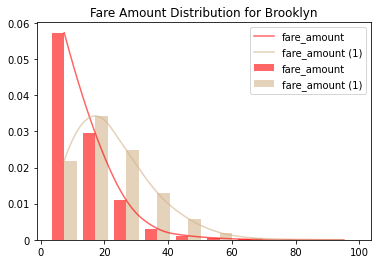

In [88]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount and Brooklyn")

pickup_borough_fares_brooklyn = train_data_filtered.filter(F.col("pickup_borough") == "brooklyn").select(F.col("fare_amount"))
dropoff_borough_fares_brooklyn = train_data_filtered.filter(F.col("dropoff_borough") == "brooklyn").select(F.col("fare_amount"))
    
distplot(axes, [pickup_borough_fares_brooklyn.select(F.col(("fare_amount"))), dropoff_borough_fares_brooklyn.select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Brooklyn")
axes.legend()

plt.show()

In [61]:
downtown_manhattan_boundary={
    'min_lng': -74.0194,
    'min_lat': 40.6997,           
    'max_lng': -73.9716,        
    'max_lat': 40.7427
}

In [62]:
def isDownTownManhattan(lat,lng):

    if (lat >= downtown_manhattan_boundary['min_lat'] and 
        lat <= downtown_manhattan_boundary['max_lat'] and 
        lng >= downtown_manhattan_boundary['min_lng'] and 
        lng <= downtown_manhattan_boundary['max_lng']):
        return True
    else:
        return False

manhattanUDF = udf(lambda x,y : isDownTownManhattan(x, y),BooleanType())
spark.udf.register("manhattanUDF", manhattanUDF)

<function __main__.<lambda>(x, y)>

In [63]:
####

In [65]:
train_data_filtered = train_data_filtered.withColumn("is_pickup_in_downtown_manhattan", 
                                                     manhattanUDF(F.col("pickup_latitude"),\
                                                     F.col("pickup_longitude")))
train_data_filtered = train_data_filtered.withColumn("is_drop_in_downtown_manhattan", 
                                                     manhattanUDF(F.col("dropoff_latitude"),\
                                                     F.col("dropoff_longitude")))

train_data_filtered.show(7)


+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+-----------+----------+-----------+------------------+------------+-----------+-------------+--------------+-------------+--------------+-------------------+--------------------+------------------+--------------+---------------+-------------------------------+-----------------------------+
|                 key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|pickup_date|pickup_day|pickup_hour|pickup_day_of_week|pickup_month|pickup_year|is_pickup_JFK|is_dropoff_JFK|is_pickup_EWR|is_dropoff_EWR|is_pickup_LaGuardia|is_dropoff_LaGuardia|     trip_distance|pickup_borough|dropoff_borough|is_pickup_in_downtown_manhattan|is_drop_in_downtown_manhattan|
+--------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+----

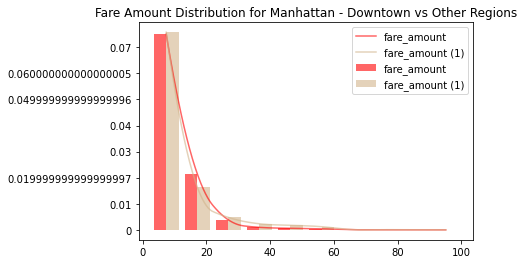

In [66]:
fig = plt.figure()
axes = plt.gca()
plt.title("Distribution of Fare Amount - Downtown Manhattan vs Other Regions in Manhattan")

lower_manhattan_pickup = train_data_filtered.filter(F.col("is_pickup_in_downtown_manhattan") == True).select(F.col("fare_amount"))
other_manhattan_pickup = train_data_filtered.filter(F.col("is_pickup_in_downtown_manhattan") == False).select(F.col("fare_amount"))
    
distplot(axes, [lower_manhattan_pickup.select(F.col(("fare_amount"))), other_manhattan_pickup.select(F.col(("fare_amount")))],\
        alpha = 0.6, color = ['red', 'tan'])
    
axes.set_title("Fare Amount Distribution for Manhattan - Downtown vs Other Regions")
axes.legend()

plt.show()

In [67]:
trips_by_year = train_data_filtered.groupBy("pickup_year").count().toPandas()
trips_by_year = trips_by_year.sort_values(by = "pickup_year")
trips_by_year

,pickup_year,count
4,2009,8432908
5,2010,8168683
6,2011,8504583
3,2012,8629726
1,2013,8476306
2,2014,8068283
0,2015,3777269


In [68]:
print(trips_by_year)

   pickup_year    count
4         2009  8432908
5         2010  8168683
6         2011  8504583
3         2012  8629726
1         2013  8476306
2         2014  8068283
0         2015  3777269


Text(0.5, 1.0, 'Trips per year')

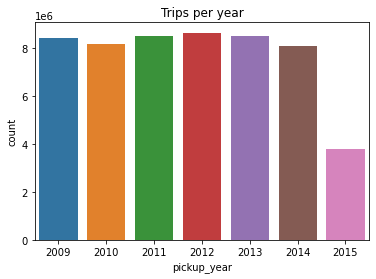

In [69]:
fig = plt.figure()

sns.barplot(x = "pickup_year",
            y = "count",
            data = trips_by_year).set_title("Trips per year")

In [70]:
by_month = train_data_filtered.groupBy("pickup_month").count().toPandas()
by_month = by_month.sort_values(by = "pickup_month")
by_month

,pickup_month,count
1,1,4817304
11,2,4545047
3,3,5069527
6,4,4984445
4,5,5082105
2,6,4862991
8,7,4098227
7,8,3856419
5,9,4118322
9,10,4368670


Text(0.5, 1.0, 'Total trips per month')

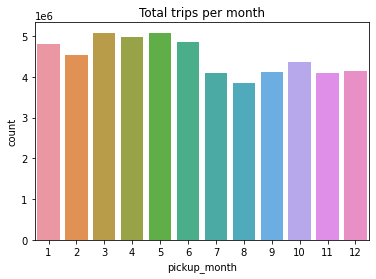

In [72]:
fig = plt.figure()

sns.barplot(x = "pickup_month",
            y = "count",
            data = by_month).set_title("Total trips per month")

In [73]:
by_day = train_data_filtered.groupBy("pickup_day_of_week").count().toPandas()
by_day = by_day.sort_values(by = "pickup_day_of_week")
by_day

,pickup_day_of_week,count
0,1,7090814
6,2,6929640
2,3,7573406
4,4,7842666
3,5,8099058
1,6,8317144
5,7,8205030


Text(0.5, 1.0, 'Trips per day of week (1 is Sunday and starting Sunday.)')

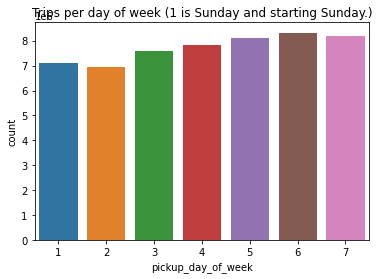

In [74]:
fig = plt.figure()

sns.barplot(x = "pickup_day_of_week",
            y = "count",
            data = by_day).set_title("Trips per day of week (1 is Sunday and starting Sunday.)")

In [75]:
by_hour = train_data_filtered.groupBy("pickup_hour").count().toPandas()
by_hour = by_hour.sort_values(by = "pickup_hour")
by_hour

,pickup_hour,count
22,0,2139866
2,1,1584703
21,2,1181754
6,3,865742
13,4,627217
8,5,528350
5,6,1108962
16,7,1946680
14,8,2455370
12,9,2526974


Text(0.5, 1.0, 'Trips per hour')

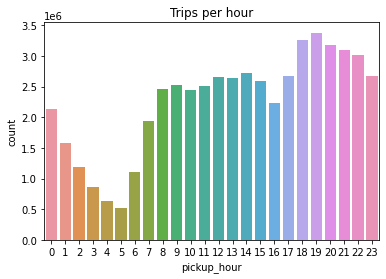

In [76]:
fig = plt.figure()

sns.barplot(x = "pickup_hour",
            y = "count",
            data = by_hour).set_title("Trips per hour")

In [77]:
avg_fares_year = train_data_filtered.select("pickup_year", "fare_amount").groupBy("pickup_year").mean().toPandas()
avg_fares_year.sort_values(by = "pickup_year", inplace = True)
print (avg_fares_year)

   pickup_year  avg(pickup_year)  avg(fare_amount)
4         2009            2009.0         10.036191
5         2010            2010.0         10.137589
6         2011            2011.0         10.425817
3         2012            2012.0         11.124391
1         2013            2013.0         12.506418
2         2014            2014.0         12.824710
0         2015            2015.0         12.887004


Text(0.5, 1.0, 'Average Fares Each Year')

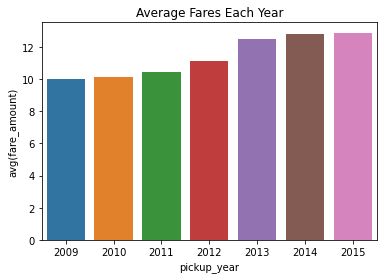

In [78]:
fig = plt.figure()

sns.barplot(x = "pickup_year",
            y = "avg(fare_amount)",
            data = avg_fares_year).set_title("Average Fares Each Year")

In [79]:
avg_fares_month = train_data_filtered.select("pickup_month", "fare_amount").
groupBy("pickup_month").mean().toPandas()
avg_fares_month.sort_values(by = "pickup_month", inplace = True)
avg_fares_month

,pickup_month,avg(pickup_month),avg(fare_amount)
1,1,1.0,10.690427
11,2,2.0,10.850605
3,3,3.0,11.135737
6,4,4.0,11.258153
4,5,5.0,11.539938
2,6,6.0,11.506472
8,7,7.0,11.067508
7,8,8.0,11.175669
5,9,9.0,11.675097
9,10,10.0,11.589168


Text(0.5, 1.0, 'Average Fares by Each Month')

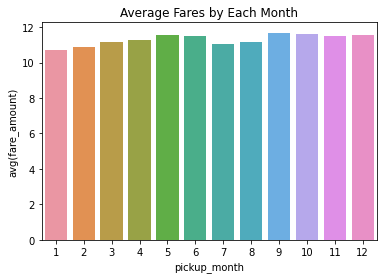

In [80]:
fig = plt.figure()

sns.barplot(x = "pickup_month",
            y = "avg(fare_amount)",
            data = avg_fares_month).set_title("Average Fares by Each Month")

In [81]:
avg_fares_day = train_data_filtered.select("pickup_day_of_week", "fare_amount").
groupBy("pickup_day_of_week").mean().toPandas()
avg_fares_day.sort_values(by = "pickup_day_of_week", inplace = True)
avg_fares_day

,pickup_day_of_week,avg(pickup_day_of_week),avg(fare_amount)
0,1,1.0,11.583543
6,2,2.0,11.320434
2,3,3.0,11.138204
4,4,4.0,11.257655
3,5,5.0,11.441898
1,6,6.0,11.368184
5,7,7.0,10.947569


In [82]:
print(avg_fares_day)

   pickup_day_of_week  avg(pickup_day_of_week)  avg(fare_amount)
0                   1                      1.0         11.583543
6                   2                      2.0         11.320434
2                   3                      3.0         11.138204
4                   4                      4.0         11.257655
3                   5                      5.0         11.441898
1                   6                      6.0         11.368184
5                   7                      7.0         10.947569


Text(0.5, 1.0, 'Average Fares for Each Day (starting by 1 is Sunday)')

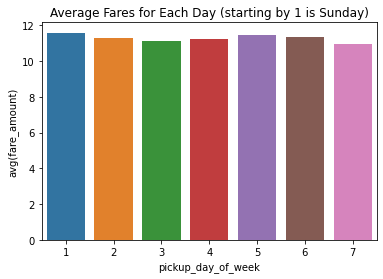

In [83]:
fig = plt.figure()

sns.barplot(x = "pickup_day_of_week",
            y = "avg(fare_amount)",
            data = avg_fares_day).set_title("Average Fares for Each Day (starting by 1 is Sunday)")

In [84]:
avg_fares_hour = train_data_filtered.select("pickup_hour", "fare_amount").groupBy("pickup_hour").mean().toPandas()
avg_fares_hour.sort_values(by = "pickup_hour", inplace = True)
avg_fares_hour

,pickup_hour,avg(pickup_hour),avg(fare_amount)
22,0,0.0,11.622322
2,1,1.0,11.349003
21,2,2.0,11.331435
6,3,3.0,11.786527
13,4,4.0,13.521306
8,5,5.0,15.098579
5,6,6.0,12.128896
16,7,7.0,10.955931
14,8,8.0,10.877159
12,9,9.0,10.831554


Text(0.5, 1.0, 'Average Fares for Each Hour')

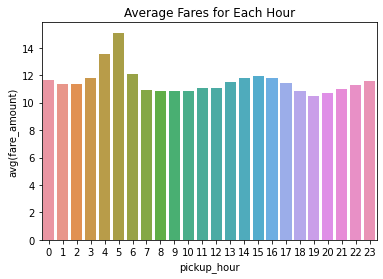

In [85]:
fig = plt.figure()

sns.barplot(x = "pickup_hour",
            y = "avg(fare_amount)",
            data = avg_fares_hour).set_title("Average Fares for Each Hour")